In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm import trange

import matplotlib.pyplot as plt

In [2]:
MNIST_ROOT = "/checkpoint/wesbz/Datasets"
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42
batch_size = 128

In [3]:
torch.manual_seed(seed)

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

mnist = MNIST(MNIST_ROOT, train=True, download=True, transform=transform)
transform_loader = DataLoader(mnist, batch_size=60_000, shuffle=False)
tfmd_data = next(iter(transform_loader))
mnist_dataset = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

mnist_test = MNIST(MNIST_ROOT, train=False, download=True, transform=transform)
transform_loader = DataLoader(mnist_test, batch_size=10_000, shuffle=False)
tfmd_data = next(iter(transform_loader))
test_data = TensorDataset(tfmd_data[0].to(device), tfmd_data[1].to(device))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [82]:
n_h = 10
torch.manual_seed(seed)
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=n_h),
    nn.ReLU(),
    nn.Linear(in_features=n_h, out_features=10)
)

model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=10, bias=True)
  (10): ReLU()
  (11): Linear(in_features=10, out_features=10, bias=True)
)

In [83]:
lr = 1e-1
epochs = 10
# Training
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (epoch+1))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)

hist_train_acc = []
hist_train_loss = []

In [84]:
with trange(epochs) as t:
    for _ in t:

        model.train()

        train_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        train_loss /= len(train_loader)

        # print(f"Train accuarcy: {100. * correct / total:.3f}%")
        train_acc = 100. * correct / total
        hist_train_acc.append(100. * correct / total)
        hist_train_loss.append(train_loss)

        # scheduler.step()

        t.set_postfix(train_acc=train_acc)

test_loss = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        test_loss += loss.item()
        _, predicted = y_pred.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

test_loss /= len(test_loader)

print(f"Test accuracy: {100. * correct / total}%")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s, train_acc=99.4]

Test accuracy: 98.57%


In [85]:
model.eval()
first_weights = model[-3].weight.detach().clone()

In [86]:
first_weights
print(torch.linalg.svdvals(first_weights))
print(torch.linalg.eigvals(first_weights))

tensor([1.7460, 1.6991, 1.6425, 1.5064, 1.3509, 1.3034, 0.7694, 0.5875, 0.5087,
        0.0463], device='cuda:0')
tensor([-0.9332+0.2733j, -0.9332-0.2733j, -0.4511+0.8593j, -0.4511-0.8593j,
         0.3514+0.5421j,  0.3514-0.5421j,  0.9671+0.4663j,  0.9671-0.4663j,
         0.4458+0.0000j,  0.7205+0.0000j], device='cuda:0')


In [87]:
replay_test_acc = [correct/total]
replay_test_loss = [test_loss]
replay_mapping = [torch.eye(model[-3].out_features).to(device)]
replay_weights = [model[-3].weight.detach().clone()]
replay_biases = [model[-3].bias.detach().clone()]

In [88]:
model[-3].weight.detach().clone()

tensor([[-0.0315, -0.3094, -0.2737,  0.1851, -0.2449,  0.8959, -0.1466, -0.1927,
          0.1133,  0.7169],
        [ 0.6349,  0.1106, -0.4322,  0.5786, -0.2478,  0.3383, -0.1918, -0.2834,
          0.3390, -0.2870],
        [ 0.9896, -0.3043,  0.1460, -0.0616,  0.3177, -0.4025,  0.0094,  0.4637,
          0.3385, -0.3431],
        [ 0.1934, -0.0995, -0.1706, -0.6455,  0.9671,  0.5929, -0.1448, -0.3296,
         -0.4543,  0.0668],
        [-0.2520,  0.0657, -0.1531, -0.0641, -0.0658, -0.1311,  0.2289, -0.0237,
         -0.1089, -0.1345],
        [ 0.2182,  0.2556,  0.6427,  0.5093, -0.5263,  0.3288, -0.1739, -0.2886,
         -0.5837, -0.4848],
        [ 0.2248, -0.1609,  0.0540, -0.0863, -0.2974,  0.3951,  0.2862, -0.0128,
          0.3199, -0.1921],
        [-0.4954,  0.2519, -0.1291,  0.7041,  0.8773,  0.0305,  0.1780,  0.3013,
         -0.3212, -0.3831],
        [-0.1888,  0.6484,  1.0864, -0.2049,  0.2334,  0.0074, -0.3088,  0.1202,
          0.4198,  0.2137],
        [-0.0285, -

In [89]:
model[-3].bias.detach().clone()

tensor([ 0.0943, -0.1901,  0.2863,  0.3579, -0.1977, -0.0988, -0.1218, -0.1435,
         0.0492, -0.1203], device='cuda:0')

In [90]:
model[-3].reset_parameters()

In [91]:
model[-3].weight.detach().clone()

tensor([[ 0.0714, -0.3099, -0.0642, -0.2907, -0.2174, -0.0111,  0.1494, -0.0595,
          0.0120, -0.1349],
        [-0.1634,  0.2674,  0.2087, -0.2946, -0.0709, -0.2641,  0.1734, -0.1396,
          0.0088, -0.1854],
        [-0.3116,  0.2372,  0.2961, -0.2403, -0.1915, -0.0315, -0.2839, -0.0068,
          0.2739, -0.0754],
        [-0.2841, -0.1478,  0.0945, -0.1471, -0.2066,  0.2255, -0.1416, -0.1839,
         -0.2713,  0.1708],
        [ 0.0696, -0.0984,  0.3069, -0.0195,  0.2658,  0.1345, -0.2497,  0.1985,
         -0.2472,  0.0695],
        [-0.2055,  0.2154,  0.2343,  0.1446, -0.1555, -0.2108,  0.1436, -0.0641,
         -0.1457,  0.1916],
        [-0.0563, -0.2230, -0.3018, -0.1688, -0.1709, -0.0643, -0.0121, -0.1188,
          0.0772, -0.0910],
        [ 0.0956,  0.2723, -0.1457, -0.2871,  0.3115, -0.1399,  0.0068,  0.0598,
          0.0737, -0.1081],
        [ 0.1920, -0.0025,  0.1251,  0.0915,  0.2567, -0.1081, -0.1991, -0.0919,
          0.1579, -0.1374],
        [ 0.1827,  

In [92]:
model[-3].bias.detach().clone()

tensor([ 0.3085, -0.2347,  0.0393,  0.0140,  0.1546,  0.0604,  0.2939,  0.2517,
         0.1726,  0.1063], device='cuda:0')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s, train_acc=100]


Test accuracy: 98.84%


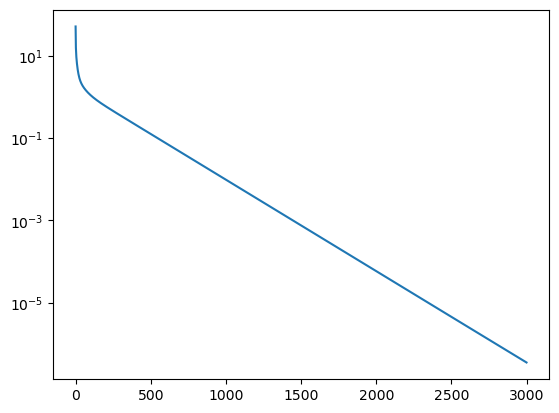

 10%|█████████████████▊                                                                                                                                                                | 1/10 [00:10<01:35, 10.67s/it]

tensor([2.4471, 1.6975, 1.3394, 1.2395, 0.8802, 0.6430, 0.5278, 0.3690, 0.2542,
        0.1130], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.7859+0.0000j,  0.5055+0.4168j,  0.5055-0.4168j, -0.4894+0.8252j,
        -0.4894-0.8252j, -0.9552+0.2072j, -0.9552-0.2072j, -0.6198+0.0000j,
         0.0195+0.3440j,  0.0195-0.3440j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it, train_acc=100]


Test accuracy: 98.96%


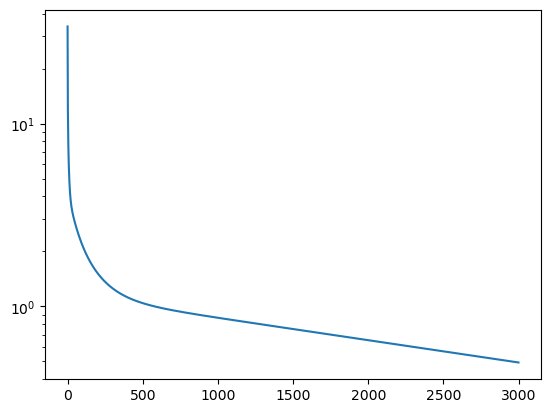

 20%|███████████████████████████████████▌                                                                                                                                              | 2/10 [00:22<01:30, 11.30s/it]

tensor([2.1817, 1.8167, 1.5297, 1.1273, 1.0835, 0.6347, 0.5948, 0.2239, 0.1350,
        0.0265], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.9567+0.0000j, -0.0714+0.8515j, -0.0714-0.8515j, -0.9572+0.0000j,
         0.1456+0.1722j,  0.1456-0.1722j, -0.3140+0.4673j, -0.3140-0.4673j,
        -0.4052+0.2087j, -0.4052-0.2087j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s, train_acc=100]


Test accuracy: 98.77%


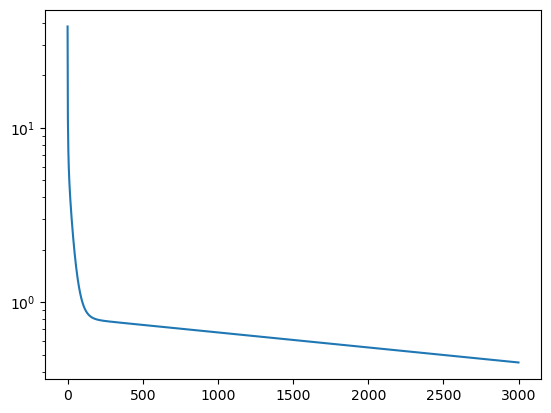

 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 3/10 [00:32<01:16, 10.89s/it]

tensor([2.2529, 1.5892, 1.3164, 1.0094, 0.8829, 0.7916, 0.5158, 0.3305, 0.2789,
        0.0223], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.6291+0.4075j, -0.6291-0.4075j, -0.2596+0.7975j, -0.2596-0.7975j,
         0.4235+0.7915j,  0.4235-0.7915j,  0.8619+0.3741j,  0.8619-0.3741j,
         0.3616+0.0000j,  0.0347+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s, train_acc=100]


Test accuracy: 98.87%


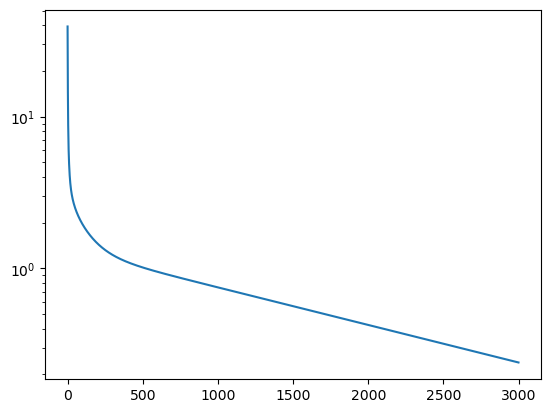

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 4/10 [00:43<01:04, 10.73s/it]

tensor([1.5669, 1.3881, 1.3426, 1.0999, 1.0379, 0.6873, 0.5091, 0.3251, 0.1510,
        0.0377], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.9031+0.0000j, -0.3224+0.8022j, -0.3224-0.8022j, -0.7216+0.5049j,
        -0.7216-0.5049j,  0.4930+0.2198j,  0.4930-0.2198j,  0.0367+0.2562j,
         0.0367-0.2562j, -0.2115+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s, train_acc=100]


Test accuracy: 98.88%


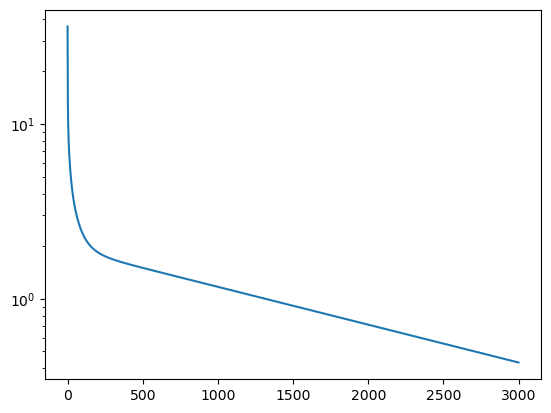

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 5/10 [00:53<00:53, 10.62s/it]

tensor([2.6629, 1.5661, 1.3195, 1.1229, 0.9792, 0.5443, 0.4550, 0.2681, 0.1873,
        0.0353], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.6348+0.8124j, -0.6348-0.8124j,  0.9108+0.0000j,  0.0917+0.7469j,
         0.0917-0.7469j, -0.4906+0.0000j, -0.3608+0.4005j, -0.3608-0.4005j,
         0.4247+0.0000j,  0.0800+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s, train_acc=100]


Test accuracy: 98.71%


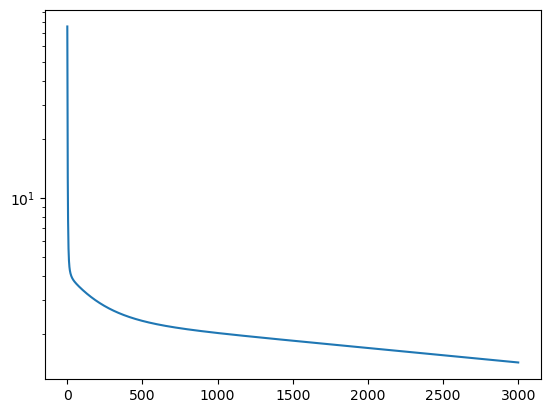

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 6/10 [01:04<00:42, 10.54s/it]

tensor([2.8022, 1.7287, 1.3121, 1.2647, 1.0965, 0.9624, 0.8448, 0.4805, 0.1110,
        0.0207], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.8882+0.9513j,  0.8882-0.9513j, -1.0846+0.0000j, -0.5614+0.8419j,
        -0.5614-0.8419j,  0.8136+0.0000j, -0.5100+0.3719j, -0.5100-0.3719j,
         0.2724+0.0000j, -0.0476+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s, train_acc=100]


Test accuracy: 98.73%


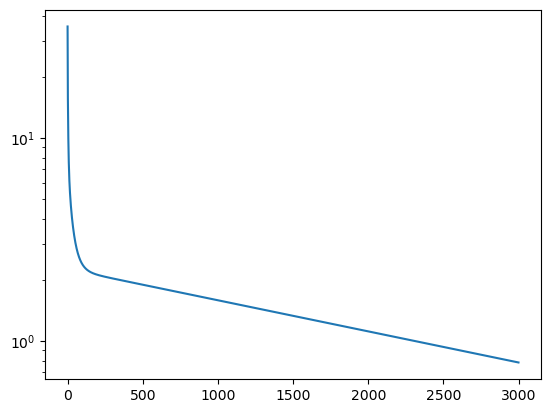

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 7/10 [01:14<00:31, 10.48s/it]

tensor([2.0122, 1.5441, 1.3998, 0.9182, 0.8265, 0.6131, 0.4468, 0.3278, 0.2559,
        0.0297], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([ 0.9083+0.0000j, -0.7627+0.8310j, -0.7627-0.8310j,  0.3305+0.0000j,
         0.0633+0.4146j,  0.0633-0.4146j, -0.5249+0.4422j, -0.5249-0.4422j,
        -0.1822+0.0000j, -0.3907+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s, train_acc=100]


Test accuracy: 98.72%


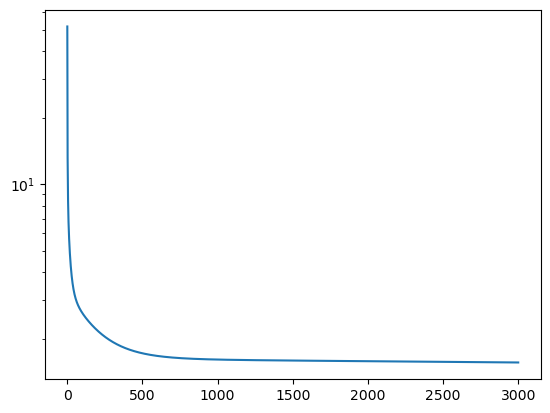

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 8/10 [01:25<00:21, 10.52s/it]

tensor([2.3014, 1.6571, 1.4016, 1.1348, 1.0926, 0.7895, 0.4726, 0.3605, 0.1182,
        0.0057], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-1.0764+0.0000j,  0.7029+0.1792j,  0.7029-0.1792j, -0.2029+0.7695j,
        -0.2029-0.7695j, -0.4268+0.5217j, -0.4268-0.5217j,  0.0677+0.0000j,
        -0.1939+0.1312j, -0.1939-0.1312j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s, train_acc=100]


Test accuracy: 98.7%


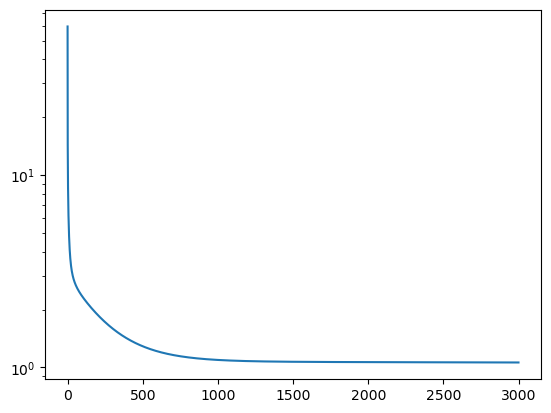

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9/10 [01:35<00:10, 10.58s/it]

tensor([2.2458, 1.6765, 1.5132, 1.1446, 0.8901, 0.7343, 0.5721, 0.3543, 0.1045,
        0.0031], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.9980+0.4732j, -0.9980-0.4732j, -0.4705+0.4602j, -0.4705-0.4602j,
         1.0378+0.0000j,  0.2800+0.5872j,  0.2800-0.5872j,  0.5622+0.0000j,
        -0.0072+0.0000j,  0.2985+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s, train_acc=100]


Test accuracy: 98.6%


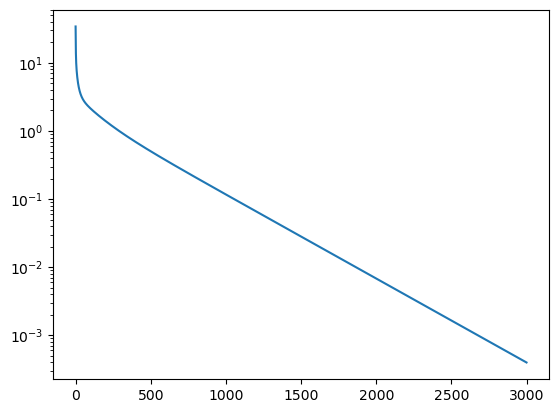

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.66s/it]

tensor([1.9250, 1.5065, 1.3090, 1.2441, 0.7651, 0.6403, 0.4868, 0.3697, 0.1453,
        0.0842], device='cuda:0', grad_fn=<LinalgSvdBackward0>)
tensor([-0.3650+0.9825j, -0.3650-0.9825j,  0.9331+0.0000j,  0.7523+0.0000j,
        -0.6634+0.4809j, -0.6634-0.4809j, -0.5317+0.0000j, -0.1283+0.3057j,
        -0.1283-0.3057j,  0.1684+0.0000j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)


In [78]:
torch.seed()
for replay in trange(10):
    model[-3].reset_parameters()
    with trange(epochs) as t:
        for _ in t:

            model[-3].train()

            train_loss = 0.0
            correct = 0
            total = 0

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()

                y_pred = model(X)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = y_pred.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

            train_loss /= len(train_loader)

            # print(f"Train accuarcy: {100. * correct / total:.3f}%")
            train_acc = 100. * correct / total
            hist_train_acc.append(100. * correct / total)
            hist_train_loss.append(train_loss)

            # scheduler.step()

            t.set_postfix(train_acc=train_acc)

    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

    test_loss /= len(test_loader)

    print(f"Test accuracy: {100. * correct / total}%")

    replay_test_acc.append(correct/total)
    replay_test_loss.append(test_loss)
    replay_weights.append(model[-3].weight.detach().clone())
    replay_biases.append(model[-3].bias.detach().clone())

    # Get the mapping
    A = torch.rand(model[-3].out_features, model[-3].out_features).to(device)
    A.requires_grad = True
    map_optimizer = optim.SGD([A], lr=1e-1)
    hist_map_loss = []
    for _ in range(3_000):
        map_optimizer.zero_grad()
        loss = torch.norm(A @ model[-3].weight - first_weights)**2
        loss.backward()
        hist_map_loss.append(loss.item())
        map_optimizer.step()
    plt.figure()
    plt.plot(hist_map_loss)
    plt.yscale("log")
    plt.show(block=False)
    print(torch.linalg.svdvals(model[-3].weight))
    print(torch.linalg.eigvals(model[-3].weight))
    replay_mapping.append(A)


In [74]:
replay_mapping

[tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0'),
 tensor([[ 0.7541, -0.1792, -0.1250, -0.0913,  0.3609, -0.7529, -0.1746, -0.1677,
          -0.2402,  0.2257],
         [ 1.4800, -0.0420,  0.2209, -0.7474, -0.9640, -0.0303, -0.7661,  1.0093,
           0.7424,  0.1534],
         [ 0.4603, -0.6316,  0.9521, -0.7408, -0.8412,  0.1639, -0.2149,  0.9622,
           0.6412,  0.0441],
         [ 0.3977, -0.8158,  0.3448,  0.7715, -0.1444, -0.0415, -0.5348,  0.4325,
           0.1793,  0.0060],
         [-0.1398, -0.0471,

In [63]:
U, S, V = torch.linalg.svd(model[-3].weight)

In [64]:
S

tensor([2.9635, 1.9138, 1.1039, 0.0032], device='cuda:0',
       grad_fn=<LinalgSvdBackward0>)